In [10]:
import torch
import torch.utils.data
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import time

---
## 定义重要参数



In [11]:
init_time = time.time()

root = './data/hy6/train'

max_epoch = 50

# image_size = 128
batch_size = 64
lr = 0.002

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

print(device)

cuda:0


**********
## 数据读取

In [12]:
transform = transforms.Compose([
#     transforms.Resize(image_size),
#     transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# 图像的增强，变形，转型，归一化

dataset = torchvision.datasets.ImageFolder(root=root, transform=transform)
# 创建文件夹型的数据集
# dataset = torchvision.datasets.CelebA('./data/', transform=transform, download=False)
# dataset = torchvision.datasets.CIFAR10('./data/', transform=transform, download=False)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# 读取数据，设置读取方式 注意shuffle默认为False

classes = dataset.classes  # 获取数据集的标签名称
num_classes = len(classes)  # 获取数据集的类数

print('classes: ', classes)
print('num_classes: ', num_classes)

classes:  ['0', '1', '2', '3', '4', '5']
num_classes:  6


---
### *显示一个batch*

torch.Size([64, 3, 128, 128])
5 1 5 5 5 5 4 4 0 4 4 0 5 1 4 3 0 2 1 1 0 0 5 3 0 0 1 4 1 3 5 3 1 1 3 5 1 2 3 3 1 5 2 3 3 1 5 1 3 1 5 5 4 4 2 0 5 3 1 1 4 2 2 4


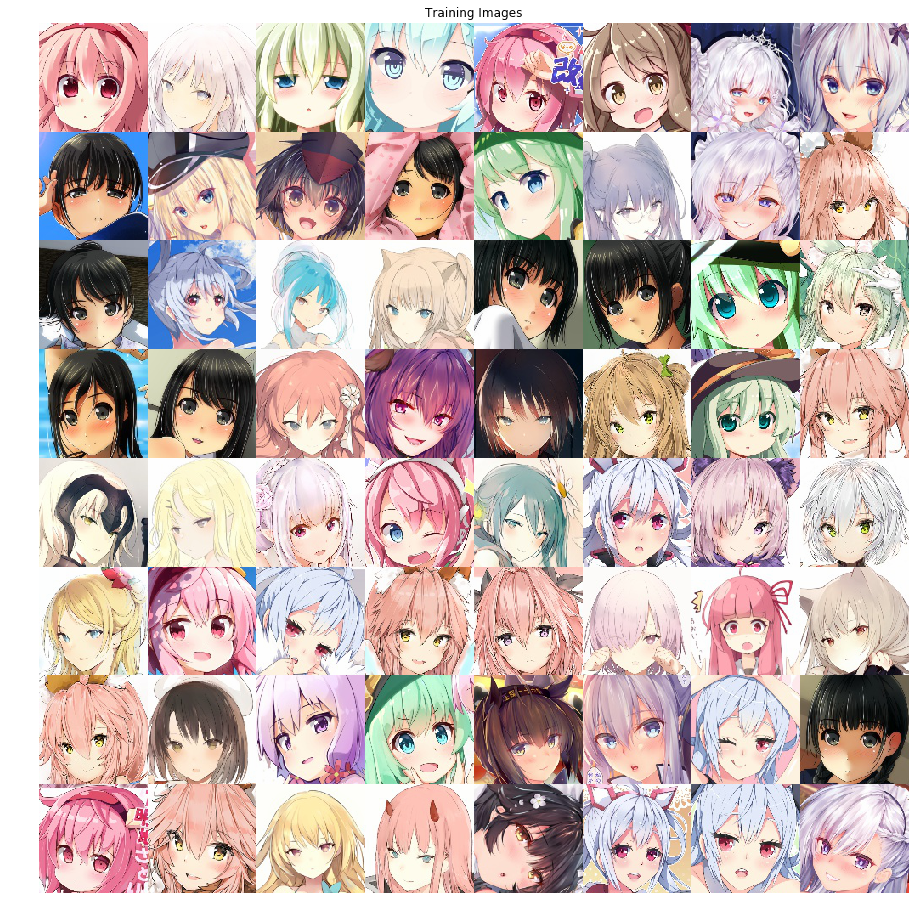

In [13]:
real_batch = next(iter(dataloader))
print(real_batch[0].shape)

print(' '.join(classes[i] for i in real_batch[1]))
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(vutils.make_grid(real_batch[0], nrow=8, padding=0, normalize=True).cpu(), (1, 2, 0)))
plt.show()

---
## 定义网络

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100, num_classes),
            # nn.Softmax(1)
        )

    def forward(self, input):
        x = self.feature(input)
        x = x.view(-1, 32 * 8 * 8)
        x = self.classifier(x)
        return x


net = Net().to(device)
# net = torchvision.models.vgg11(num_classes=num_classes).to(device)
print(net)

# 定义优化器和损失函数
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

Net(
  (feature): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=100, out_features=6, bias=True)
  )
)


---
## 训练

In [15]:
iteration = 0
loss_list = []
str_time = time.time()
print("Starting Training Loop...")

for epoch in range(max_epoch):
    for i, data in enumerate(dataloader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # optimizer.zero_grad()
        net.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            if iteration % 1 == 0:
                predicted = outputs.argmax(1)
                correct = predicted == labels
                accuracy = correct.sum().item() / len(correct)

                it_time = time.time()
                print('[%d, %5d] loss: %.3f accuracy:%.3f%% time:%.3f' %
                      (epoch, i, loss.item(), accuracy * 100, it_time - str_time))

            loss_list.append(loss.item())
            iteration += 1

print('Finished Training')

Starting Training Loop...
[0,     0] loss: 1.789 accuracy:21.875% time:0.289
[0,     1] loss: 1.770 accuracy:25.000% time:0.567
[0,     2] loss: 1.629 accuracy:25.000% time:0.814
[0,     3] loss: 1.498 accuracy:40.625% time:1.045
[0,     4] loss: 1.574 accuracy:39.062% time:1.330
[0,     5] loss: 1.313 accuracy:34.375% time:1.572
[0,     6] loss: 1.547 accuracy:26.562% time:1.815
[0,     7] loss: 1.188 accuracy:53.125% time:2.060
[0,     8] loss: 1.414 accuracy:34.375% time:2.292
[0,     9] loss: 1.443 accuracy:37.500% time:2.387
[1,     0] loss: 1.403 accuracy:46.875% time:2.456
[1,     1] loss: 1.078 accuracy:57.812% time:2.520
[1,     2] loss: 1.165 accuracy:46.875% time:2.586
[1,     3] loss: 1.003 accuracy:71.875% time:2.657
[1,     4] loss: 1.070 accuracy:59.375% time:2.731
[1,     5] loss: 1.028 accuracy:50.000% time:2.801
[1,     6] loss: 0.937 accuracy:73.438% time:2.871
[1,     7] loss: 0.915 accuracy:68.750% time:2.939
[1,     8] loss: 0.972 accuracy:68.750% time:3.010
[1,  

[15,     7] loss: 0.022 accuracy:100.000% time:12.326
[15,     8] loss: 0.015 accuracy:100.000% time:12.390
[15,     9] loss: 0.005 accuracy:100.000% time:12.423
[16,     0] loss: 0.009 accuracy:100.000% time:12.489
[16,     1] loss: 0.008 accuracy:100.000% time:12.561
[16,     2] loss: 0.007 accuracy:100.000% time:12.631
[16,     3] loss: 0.006 accuracy:100.000% time:12.708
[16,     4] loss: 0.009 accuracy:100.000% time:12.779
[16,     5] loss: 0.006 accuracy:100.000% time:12.850
[16,     6] loss: 0.013 accuracy:100.000% time:12.923
[16,     7] loss: 0.003 accuracy:100.000% time:12.997
[16,     8] loss: 0.010 accuracy:100.000% time:13.070
[16,     9] loss: 0.004 accuracy:100.000% time:13.101
[17,     0] loss: 0.010 accuracy:100.000% time:13.167
[17,     1] loss: 0.007 accuracy:100.000% time:13.233
[17,     2] loss: 0.007 accuracy:100.000% time:13.305
[17,     3] loss: 0.004 accuracy:100.000% time:13.376
[17,     4] loss: 0.004 accuracy:100.000% time:13.449
[17,     5] loss: 0.003 accu

[30,     8] loss: 0.000 accuracy:100.000% time:22.402
[30,     9] loss: 0.001 accuracy:100.000% time:22.436
[31,     0] loss: 0.001 accuracy:100.000% time:22.507
[31,     1] loss: 0.001 accuracy:100.000% time:22.578
[31,     2] loss: 0.000 accuracy:100.000% time:22.653
[31,     3] loss: 0.001 accuracy:100.000% time:22.724
[31,     4] loss: 0.001 accuracy:100.000% time:22.793
[31,     5] loss: 0.001 accuracy:100.000% time:22.864
[31,     6] loss: 0.001 accuracy:100.000% time:22.933
[31,     7] loss: 0.001 accuracy:100.000% time:23.003
[31,     8] loss: 0.000 accuracy:100.000% time:23.076
[31,     9] loss: 0.001 accuracy:100.000% time:23.109
[32,     0] loss: 0.001 accuracy:100.000% time:23.178
[32,     1] loss: 0.001 accuracy:100.000% time:23.252
[32,     2] loss: 0.001 accuracy:100.000% time:23.324
[32,     3] loss: 0.000 accuracy:100.000% time:23.398
[32,     4] loss: 0.000 accuracy:100.000% time:23.470
[32,     5] loss: 0.001 accuracy:100.000% time:23.539
[32,     6] loss: 0.001 accu

[45,     9] loss: 0.000 accuracy:100.000% time:32.640
[46,     0] loss: 0.000 accuracy:100.000% time:32.708
[46,     1] loss: 0.000 accuracy:100.000% time:32.778
[46,     2] loss: 0.000 accuracy:100.000% time:32.851
[46,     3] loss: 0.000 accuracy:100.000% time:32.924
[46,     4] loss: 0.000 accuracy:100.000% time:32.997
[46,     5] loss: 0.000 accuracy:100.000% time:33.075
[46,     6] loss: 0.000 accuracy:100.000% time:33.148
[46,     7] loss: 0.000 accuracy:100.000% time:33.220
[46,     8] loss: 0.000 accuracy:100.000% time:33.295
[46,     9] loss: 0.000 accuracy:100.000% time:33.329
[47,     0] loss: 0.000 accuracy:100.000% time:33.398
[47,     1] loss: 0.000 accuracy:100.000% time:33.470
[47,     2] loss: 0.000 accuracy:100.000% time:33.537
[47,     3] loss: 0.000 accuracy:100.000% time:33.605
[47,     4] loss: 0.000 accuracy:100.000% time:33.672
[47,     5] loss: 0.000 accuracy:100.000% time:33.739
[47,     6] loss: 0.000 accuracy:100.000% time:33.810
[47,     7] loss: 0.000 accu

---
### *画Loss图*

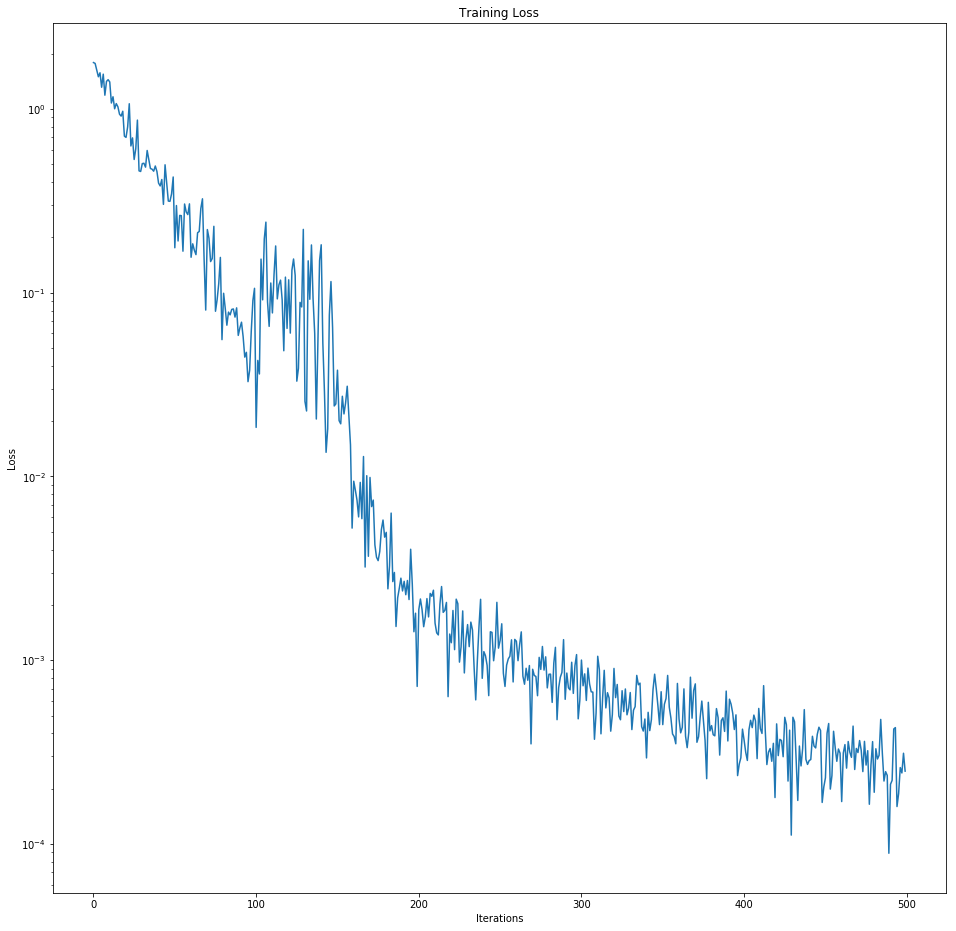

In [16]:
plt.figure(figsize=(16, 16))
plt.title('Training Loss')
plt.plot(loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
# plt.savefig('Loss.jpg')
plt.show()

---
### *测试模型*


In [17]:
print("Starting Test...")

root_test = root = './data/hy6/test'

test_set = torchvision.datasets.ImageFolder(root=root_test, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)

        predicted = torch.max(outputs, 1)[1]

        correct += (predicted == labels).sum().item()
        total += len(labels)

    accuracy = correct / total
    print('Accuracy of all test images: %.2f %%' % (accuracy * 100))

    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(num_classes):
        print('Accuracy of %8s : %.2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

Starting Test...
Accuracy of all test images: 75.33 %
Accuracy of        0 : 92.00 %
Accuracy of        1 : 80.00 %
Accuracy of        2 : 92.00 %
Accuracy of        3 : 52.00 %
Accuracy of        4 : 52.00 %
Accuracy of        5 : 84.00 %


---
### *抽查*


Samples:


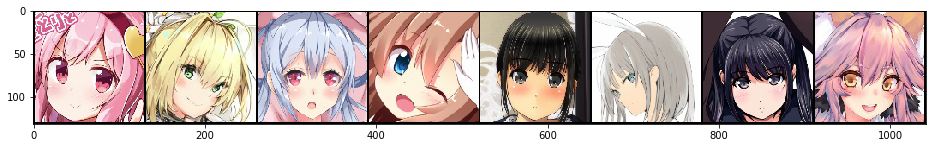

GroundTruth:      5     3     2     5     0     1     0     4
Predicted:      5     3     2     5     0     1     0     3
Accuracy of these samples: 87.50%


In [24]:
print("Samples:")

test_num = 8
data_iter = iter(test_loader)
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

plt.figure(figsize=(16, 16))
plt.imshow(
    np.transpose(torchvision.utils.make_grid(images[:test_num], nrow=8, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

# print(labels[:test_num])
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(test_num)))

outputs = net(images[:test_num])

predicted = torch.max(outputs, 1)[1]
# print(predicted[:test_num])
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(test_num)))

correct = predicted == labels[:test_num]

accuracy = correct.sum().item() / len(correct)
print('Accuracy of these samples: %.2f%%' % (accuracy * 100))

